In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry
import seaborn as sns
import datetime
import random
import pyproj
%matplotlib inline
now = datetime.datetime.now()

try:
    import pycpt
    cmap = pycpt.load.cmap_from_cptcity_url('ukmo/wow/temp-c.cpt')
except:
    cmap = 'Spectral_r'

In [5]:
column_names = 'numbername;address;position;banking;bonus;status;contract_name;bike_stand;available_bike_stand;available_bikes;last_update'.split(";")


df = pd.read_csv('./data/villo.csv', names=column_names,sep=";")

#Split position column into geocoordinates


df['latitude'], df['longitude'] = df['position'].str.split(',', 1).str
df = df[['latitude','longitude','address','position']]



In [8]:
#Generate random data
mu, sigma = 70, 10 # mean and standard deviation
s = np.random.normal(mu, sigma, len(df['latitude']))
df_final = pd.DataFrame(data=None, columns=df.columns,index=df.index)
days=1
mu, sigma = 70, 10 # mean and standard deviation
all_res = []
for i in range(1,days):
    df2 = df
    #Random number between a certain range
    r = random.randrange(-10, 10)
    s = np.random.normal(mu+r, sigma, len(df['latitude']))
    df2['pm2.5'] = s
    df_final.append(df2)
    all_res.append(df2)
    print(df2.head())
    


df = pd.concat(all_res)

df.latitude = df.latitude.astype(float).fillna(0.0)
df.longitude = df.longitude.astype(float).fillna(0.0)
# North American Datum 1927
p1 = pyproj.Proj(proj='latlong', datum='NAD27')
# WGS84 Latlong
p2 = pyproj.Proj(proj='latlong', datum='WGS84')
# WGS84 UTM Zone 16
p3 = pyproj.Proj(proj='utm', zone=16, datum='WGS84')
df['long_wgs84'], df['lat_wgs84'] = pyproj.transform(p1, p2, 
                                                            df.longitude.values, 
                                                            df.latitude.values)
df['E_utm'], df['N_utm'] = pyproj.transform(p1, p3,
                                                        df.longitude.values,
                                                        df.latitude.values)
df['geometry'] = [geometry.Point(x, y) for x, y in zip(df['long_wgs84'], df['lat_wgs84'])]



In [ ]:
df['geometry'] = [geometry.Point(x, y) for x, y in zip(df['longitude'], df['latitude'])]

df = gpd.GeoDataFrame(df, geometry='geometry', crs="+init=epsg:4326")

df.to_csv('./data/processed_data.csv')


In [23]:
df['geometry'] = [geometry.Point(x, y) for x, y in zip(df['long_wgs84'], df['lat_wgs84'])]
df = gpd.GeoDataFrame(df, geometry='geometry', crs="+init=epsg:4326")



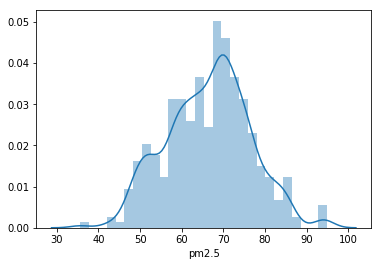

In [24]:
pm = df['pm2.5']
ax = sns.distplot(pm, axlabel='pm2.5')

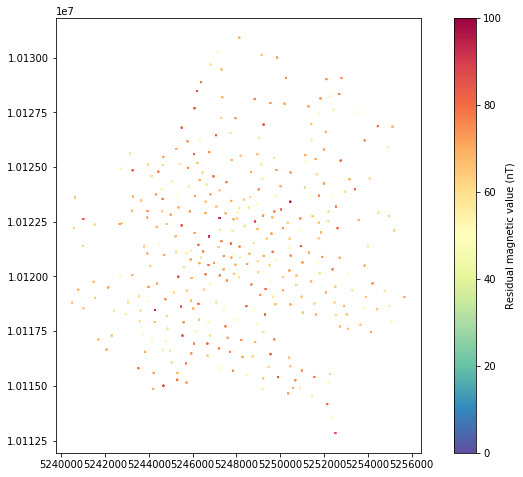

In [25]:
vmin = 0
vmax = 100
plt.scatter(df.E_utm, df.N_utm, cmap=cmap, s=1, c=pm, vmin=vmin, vmax=vmax)
plt.colorbar(label=u'Residual magnetic value (nT)')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(12, 8)

In [26]:
pixel_size = 250
#Define the range of coordinate values to be processed as a function to the pixel size.
x_range = np.arange(df.E_utm.min() - df.E_utm.min() % pixel_size,
                    df.E_utm.max(), pixel_size)
y_range = np.arange(df.N_utm.min() - df.N_utm.min() % pixel_size,
                    df.N_utm.max(), pixel_size)[::-1]

#Define the shape 
shape = (len(y_range), len(x_range))
extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()

print ('''Array info:
rows: {}, columns: {}\nxmin: {}, xmax: {}\nymin: {}, ymax: {}
'''.format(shape[0], shape[1], xmin, xmax, ymin, ymax))

x_mesh, y_mesh = np.meshgrid(x_range, y_range)
df.loc[:, 'X_INDEX'] = ((df.E_utm - xmin) / pixel_size).astype(int)
df.loc[:, 'Y_INDEX'] = (shape[0] - ((df.N_utm - ymin) / pixel_size)).astype(int)


Array info:
rows: 73, columns: 62
xmin: 5240250.0, xmax: 5255500.0
ymin: 10112750.0, ymax: 10130750.0



In [27]:
print(df)

      latitude  longitude                                            address  \
72   50.812489   4.379203  FERMÉE-TRAVAUX STIB - ULB SOLBOSCH / VUB SOLBO...   
207  50.833424   4.313378  BIESTEBROECK / BIESTEBROEK - CHEE DE MONS (FAC...   
297  50.804455   4.426369               TEN REUKEN - BD DU SOUVERAIN FACE 76   
298  50.877037   4.300847  HALL DES SPORTS - AV DES 9 PROVINCES / 9 PROVI...   
96   50.863875   4.358708  HOTEL PRESIDENT/PRESIDENT HOTEL - BOULEVARD DU...   
113  50.820042   4.374785  ABBAYE DE LA CAMBRE/ABDIJ TER KAMEREN - AVENUE...   
235  50.810085   4.324864  FOREST NATIONAL / VORST NATIONAAL - AV VICTOR ...   
36   50.845124   4.351486  PLACE ST JEAN/SINT-JANSPLEIN - RUE DU LOMBARD/...   
240  50.814180   4.347721    VANDERKINDERE - AVENUE ALBERT/ALBERTLAAN N° 272   
281  50.895485   4.341311  ATOMIUM - BOULEVARD DU CENTENAIRE / EEUWFEESTLAAN   
228  50.816525   4.336212  ALTITUDE CENT / HOOGTE HONDERD - PLACE DE L'AL...   
253  50.872475   4.314266  REINE FABIOLA

In [28]:
df = np.zeros(shape)
df[:] = np.nan
df[df.Y_INDEX, df.X_INDEX] = pm

AttributeError: 'numpy.ndarray' object has no attribute 'Y_INDEX'

In [29]:
df.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

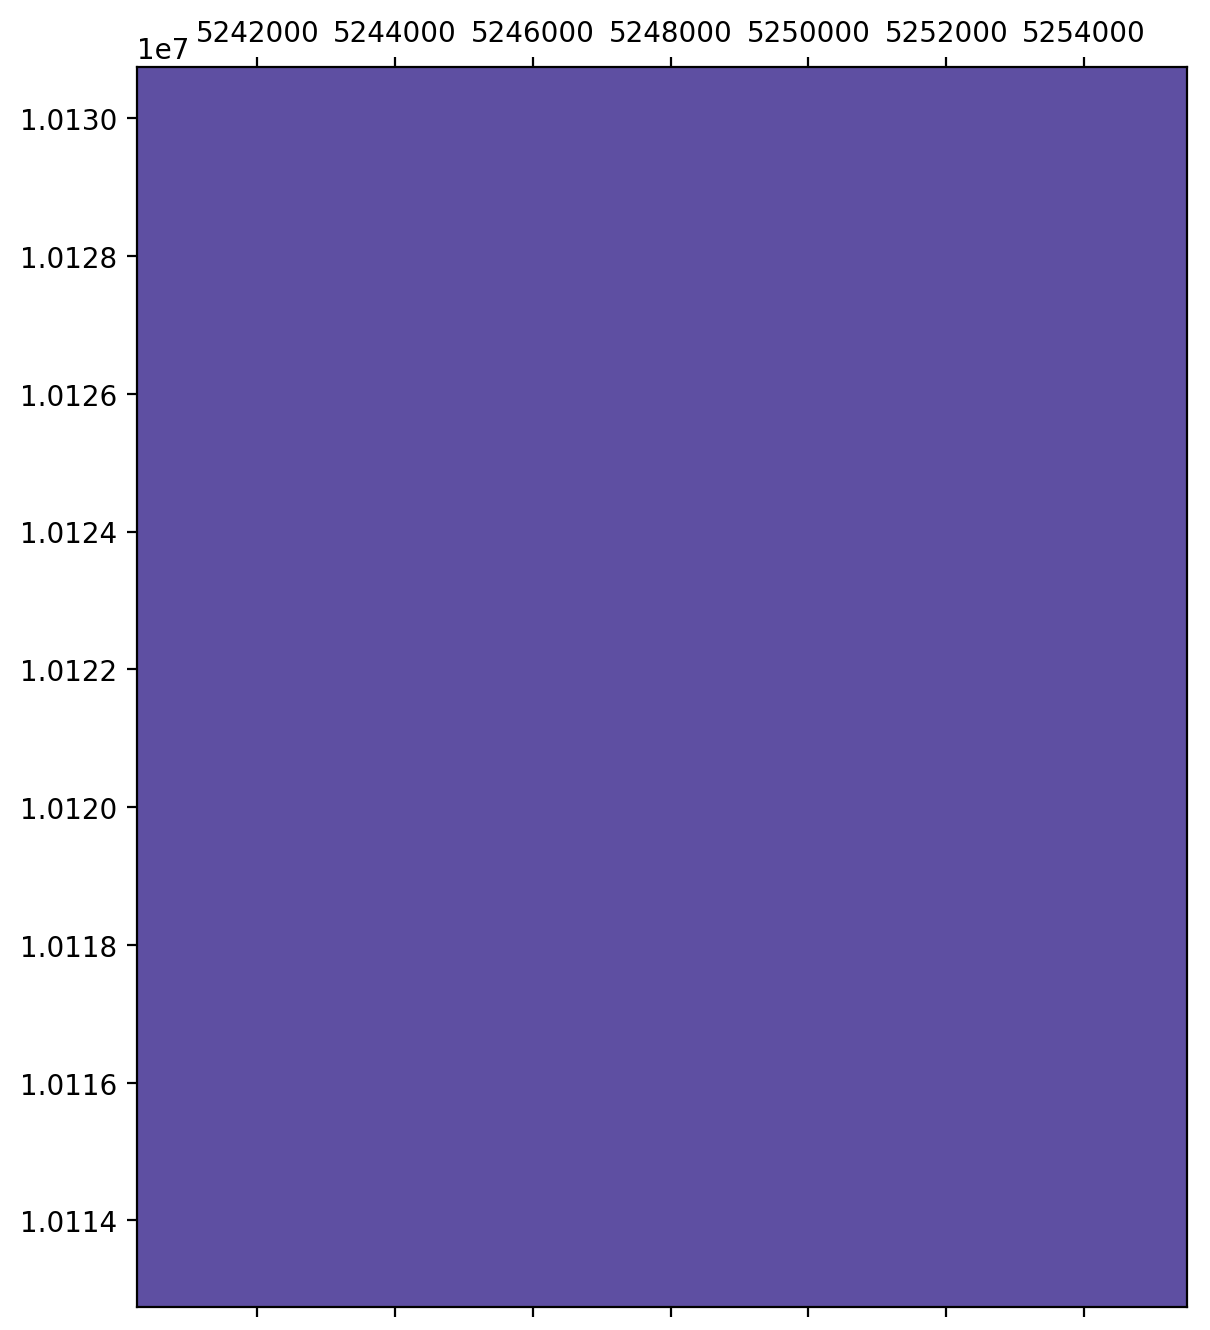

In [303]:
plt.matshow(df, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(200)